In [1]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 972.2/972.2 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.4 MB/s eta 0:00:00

In [3]:
%load_ext tensorboard

In [4]:
!rm -rf ./logs/

In [5]:
!rm -rf /content/lightning_logs

# Data preprocessing

In [2]:
import pandas as pd
import statistics
import wandb
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.dates as mdates
import tensorflow as tf
from scipy.stats import norm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler, MaxAbsScaler,MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Bidirectional, Conv1D, MaxPooling1D,Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.layers import Dropout
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)

warnings.simplefilter('ignore', ConvergenceWarning)

In [3]:
df=pd.read_excel('/content/drive/MyDrive/Oil and Gas Project(Data Science)/Data/DataRecivedOnJan272025/HeavyOlefinsTanks.xlsx',sheet_name='Temp Data',skiprows=3)
df.drop(index=[0,1,2,3,4],inplace=True)
# Rename the 'Unnamed: 0' column to 'Time'
df = df.rename(columns={'Unnamed: 0': 'Time'})
df = df.reset_index(drop=True)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [4]:
len(df)

6361

In [5]:
df = df.dropna()

In [6]:
len(df)

1613

In [7]:
df.index = pd.to_datetime(df['Time'],errors='coerce')
df['Time'] = pd.to_datetime(df['Time'],errors='coerce')
# df.drop(columns=['Time'],axis=True,inplace=True)
full_range = pd.date_range(start=df.index.min(), end=df.index.max())
missing_dates = full_range.difference(df.index)
print("Missing dates in the dataset are:", missing_dates)

Missing dates in the dataset are: DatetimeIndex([], dtype='datetime64[ns]', freq='D')


In [8]:
# Function to replace strings with NaN and keep track of the original strings
def replace_strings_with_nan(column):
    # Check if the column data type is object, which is typically used for strings in pandas
    if column.dtype == object:
        # Identify if each element is a string that cannot be converted to a number
        is_string = column.apply(lambda x: isinstance(x, str) and not x.replace('.', '', 1).isdigit())
        # Store original strings before replacement
        original_strings = column[is_string]
        # Replace strings with NaN
        column[is_string] = np.nan
        return column, original_strings
    else:
        # If not object type, return the column unchanged
        return column, pd.Series([])

# Apply the function to each column in the DataFrame
transformed_columns = {}
original_strings_per_column = {}

for col in df.columns:
    df[col], original_strings = replace_strings_with_nan(df[col])
    if not original_strings.empty:
        transformed_columns[col] = df[col]
        original_strings_per_column[col] = original_strings

# Displaying the original strings that were replaced
print("Original strings that were replaced with NaN:")
for col, strings in original_strings_per_column.items():
    print(f"Column '{col}':")
    print(strings)

for c in df.columns:
   df[c] = pd.to_numeric(df[c], errors='coerce')

df=df.interpolate()

Original strings that were replaced with NaN:
Column 'TBD910':
Time
2021-10-28 12:00:00    Not Connect
2023-06-26 12:00:00      Configure
Name: TBD910, dtype: object
Column 'TBD911':
Time
2021-10-28 12:00:00    Not Connect
2023-06-26 12:00:00      Configure
2024-04-15 12:00:00      Unit Down
2024-04-16 12:00:00      Unit Down
2024-04-17 12:00:00      Unit Down
2024-04-18 12:00:00      Unit Down
2024-04-19 12:00:00      Unit Down
2024-04-20 12:00:00      Unit Down
2024-04-21 12:00:00      Unit Down
2024-04-22 12:00:00      Unit Down
2024-04-23 12:00:00      Unit Down
2024-04-24 12:00:00      Unit Down
2024-04-25 12:00:00      Unit Down
2024-04-26 12:00:00      Unit Down
2024-04-27 12:00:00      Unit Down
2024-04-28 12:00:00      Unit Down
2024-04-29 12:00:00      Unit Down
2024-04-30 12:00:00      Unit Down
2024-05-01 12:00:00      Unit Down
2024-05-02 12:00:00      Unit Down
2024-05-03 12:00:00      Unit Down
2024-05-04 12:00:00      Unit Down
2024-05-05 12:00:00      Unit Down
2024-05

<ipython-input-8-ac864bdbe4db>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column[is_string] = np.nan
<ipython-input-8-ac864bdbe4db>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column[is_string] = np.nan
<ipython-input-8-ac864bdbe4db>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column[is_string] = np.nan


# Nbeats

In [11]:
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.metrics import mape, rmse, mae
from darts.utils.statistics import plot_acf

In [12]:
df.columns

Index(['Time', 'TBD910', 'TBD911', 'TBD912'], dtype='object')

In [13]:
# prompt: check duplicates in time column

# Check for duplicates in the 'Time' column
duplicate_times = df[df['Time'].duplicated(keep=False)]

if not duplicate_times.empty:
    print("Duplicate timestamps found:")
    print(duplicate_times)
else:
    print("No duplicate timestamps found in the 'Time' column.")


No duplicate timestamps found in the 'Time' column.


In [117]:
df['TBD911']= df['TBD911'][:-48]

In [118]:
len(df)

1613

In [121]:
df.dropna(axis=0,inplace=True)

In [122]:
df['TBD911'].tail(50)

,TBD911
Time,
2024-02-24 12:00:00,70.553017
2024-02-25 12:00:00,72.226143
2024-02-26 12:00:00,72.409851
2024-02-27 12:00:00,77.376457
2024-02-28 12:00:00,70.956360
2024-02-29 12:00:00,59.500713
2024-03-01 12:00:00,60.626335
2024-03-02 12:00:00,67.354576
2024-03-03 12:00:00,69.532295


In [123]:
series = TimeSeries.from_dataframe(df, time_col='Time', value_cols="TBD911")

In [124]:
len(series)

1565

In [125]:
train, val = series.split_before(0.75)
val, test = val.split_before(0.10)

In [126]:
from darts.dataprocessing.transformers import Scaler
scaler = Scaler()
train_scaled = scaler.fit_transform(train)
val_scaled = scaler.transform(val)
test_scaled = scaler.transform(test)


In [127]:
len(train)

1173

In [128]:
len(val)

39

In [129]:
len(test)

353

In [130]:
from pytorch_lightning.loggers import TensorBoardLogger
from torch.optim.lr_scheduler import StepLR
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import Callback # Import the Callback class

class LossLogger(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        train_loss = trainer.callback_metrics.get("train_loss")
        val_loss = trainer.callback_metrics.get("val_loss")

        # Check if the metrics are available before formatting
        train_loss_str = f"{train_loss:.4f}" if train_loss is not None else "N/A"
        val_loss_str = f"{val_loss:.4f}" if val_loss is not None else "N/A"

        print(f"Epoch {trainer.current_epoch}: Train Loss = {train_loss_str}, Val Loss = {val_loss_str}")

    def on_train_end(self, trainer, pl_module):

        print("Training finished.")

In [131]:
# model = NBEATSModel(input_chunk_length=200, output_chunk_length=5, n_epochs=200, random_state=42, pl_trainer_kwargs={"callbacks": [LossLogger()]})

In [23]:

# tensorboard_logger = TensorBoardLogger(
#     save_dir="logs",  # Directory to save TensorBoard logs
#     name="nbeats_model"  # Experiment name
# )


In [24]:

# stop training when validation loss does not decrease more than 0.05 (`min_delta`) over
# a period of 5 epochs (`patience`)
my_stopper = EarlyStopping(
    monitor="val_loss",
    patience=10,
    min_delta=1.0,
    mode='min',
)

# pl_trainer_kwargs={"logger": tensorboard_logger,"callbacks": [ LossLogger()]}

# pl_trainer_kwargs={
#         'logger': logger,
#         'log_every_n_steps': 10
#     }

pl_trainer_kwargs={
        'logger': True,  # Enables PyTorch Lightning's default logger (TensorBoard)
        'enable_checkpointing': False  # Depends on your need for model checkpointing
    }
# pl_trainer_kwargs={'logger': logger, 'log_every_n_steps': 10}


In [132]:
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import Trainer, LightningModule
class LitModel(LightningModule):
    def training_step(self, batch, batch_idx):
        # Perform training step and compute loss
        loss = self.compute_loss(batch)
        # Log the training loss
        self.log('train_loss', loss, on_step=False, on_epoch=True, logger=True)
        print("Train Loss:",loss)
        return loss

    def validation_step(self, batch, batch_idx):
        # Perform validation step and compute validation loss
        val_loss = self.compute_val_loss(batch)
        # Log the validation loss
        self.log('val_loss', val_loss, on_step=False, on_epoch=True, logger=True)
        print("Val Loss:",val_loss)
        return val_loss

In [133]:
# logger = TensorBoardLogger('tb_logs', name='my_model')

In [134]:
pl_trainer_kwargs={
        'logger': True,  # Enables PyTorch Lightning's default logger (TensorBoard)
        'enable_checkpointing': False,  # Depends on your need for model checkpointing
        "callbacks": [ LossLogger() ]
        }


#Latest

In [135]:
from pytorch_lightning.callbacks import Callback

class LossLogger(Callback):
    def __init__(self):
        self.train_loss = []
        self.val_loss = []

    # will automatically be called at the end of each epoch
    def on_train_epoch_end(self, trainer: "pl.Trainer", pl_module: "pl.LightningModule") -> None:
        self.train_loss.append(float(trainer.callback_metrics["train_loss"]))
        print(f'''Epoch {trainer.current_epoch}: Train Loss = {
             float(trainer.callback_metrics["train_loss"])
                   }'''
                   )

    def on_validation_epoch_end(self, trainer: "pl.Trainer", pl_module: "pl.LightningModule") -> None:
        self.val_loss.append(float(trainer.callback_metrics["val_loss"]))
        print(f'''Epoch {trainer.current_epoch}: Val Loss = {
             float(trainer.callback_metrics["val_loss"])
                   }'''
                   )
        print("*"*20)


In [186]:
loss_logger = LossLogger()

early_stop_callback = EarlyStopping(
    monitor="val_loss",      # Metric to monitor
    min_delta=0.000,          # Minimum change to qualify as an improvement
    patience=10,             # Number of epochs with no improvement to wait before stopping
    verbose=True,            # Print a message when early stopping is triggered
    mode="min",              # We want to minimize the validation loss
    check_on_train_epoch_end=True  # Ensure it checks at the end of each epoch
)

pl_trainer_kwargs={
        'logger': True,  # Enables PyTorch Lightning's default logger (TensorBoard)
        'enable_checkpointing': False,  # Depends on your need for model checkpointing
        'log_every_n_steps':10,
        "callbacks": [ loss_logger,early_stop_callback ]
        }
# pl_trainer_kwargs={"callbacks": [loss_logger]}

In [187]:
input_chunk_length = 30  # Number of past observations used for prediction
output_chunk_length = 10
model = NBEATSModel(input_chunk_length=output_chunk_length, output_chunk_length=output_chunk_length, n_epochs=2000, dropout=0.2,generic_architecture=True,num_stacks=2,num_blocks=20, num_layers=10,
                    #  lr_scheduler_cls=StepLR,
                    batch_size=32,
                    nr_epochs_val_period=1,
    #lr_scheduler_kwargs={"step_size": 10, "gamma": 0.1},
                    random_state=42, optimizer_kwargs={"lr": 0.0001}, pl_trainer_kwargs=pl_trainer_kwargs)

In [188]:
model.fit(train_scaled,val_series=val_scaled,verbose=True,)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 23.9 M | train
-------------------------------------------------------------
23.9 M    Trainable params
1.3 K     Non-trainable params
23.9 M    Total params
95.621    Total estimated m

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0: Val Loss = 4.474696551647847
********************


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.067


Epoch 0: Val Loss = 0.06714077684125674
********************
Epoch 0: Train Loss = 0.12951268070020291


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.062 >= min_delta = 0.0. New best score: 0.005


Epoch 1: Val Loss = 0.005193692241446919
********************
Epoch 1: Train Loss = 0.03485019790861232


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: Val Loss = 0.006538318853054582
********************
Epoch 2: Train Loss = 0.013664204322380913


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: Val Loss = 0.008237810530799297
********************
Epoch 3: Train Loss = 0.03051861562501621


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: Val Loss = 0.008100580319303005
********************
Epoch 4: Train Loss = 0.05419126504623285


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5: Val Loss = 0.005453036858904244
********************
Epoch 5: Train Loss = 0.008990157646780723


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6: Val Loss = 0.005999914241738724
********************
Epoch 6: Train Loss = 0.011558340240154234


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7: Val Loss = 0.00574684378263668
********************
Epoch 7: Train Loss = 0.007593050214114528


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8: Val Loss = 0.009411061764295715
********************
Epoch 8: Train Loss = 0.07154081339058763


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.004


Epoch 9: Val Loss = 0.0044960443776969365
********************
Epoch 9: Train Loss = 0.019296276703914136


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10: Val Loss = 0.0077738536503128165
********************
Epoch 10: Train Loss = 0.012530151014965957


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11: Val Loss = 0.005245378130153077
********************
Epoch 11: Train Loss = 0.012439970396898814


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12: Val Loss = 0.005290521060231467
********************
Epoch 12: Train Loss = 0.010528411374094038


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13: Val Loss = 0.005758150264251856
********************
Epoch 13: Train Loss = 0.007192687371562085


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14: Val Loss = 0.004595081367037179
********************
Epoch 14: Train Loss = 0.02576667664489259


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15: Val Loss = 0.006776137214427984
********************
Epoch 15: Train Loss = 0.02569879958041086


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16: Val Loss = 0.006808104301470682
********************
Epoch 16: Train Loss = 0.009111024423677212


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17: Val Loss = 0.00540776330212907
********************
Epoch 17: Train Loss = 0.007159179650148253


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18: Val Loss = 0.006269043675263325
********************
Epoch 18: Train Loss = 0.008557953494095572


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 10 records. Best score: 0.004. Signaling Trainer to stop.


Epoch 19: Val Loss = 0.005806773024933347
********************
Epoch 19: Train Loss = 0.010479399998646693


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=2, num_blocks=20, num_layers=10, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.2, activation=ReLU, input_chunk_length=10, output_chunk_length=10, n_epochs=2000, batch_size=32, nr_epochs_val_period=1, random_state=42, optimizer_kwargs={'lr': 0.0001}, pl_trainer_kwargs={'logger': True, 'enable_checkpointing': False, 'log_every_n_steps': 10, 'callbacks': [<__main__.LossLogger object at 0x789789458510>, <pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x789788ea7210>]})

Final Train Loss: 0.0105
Final Validation Loss: 0.0058


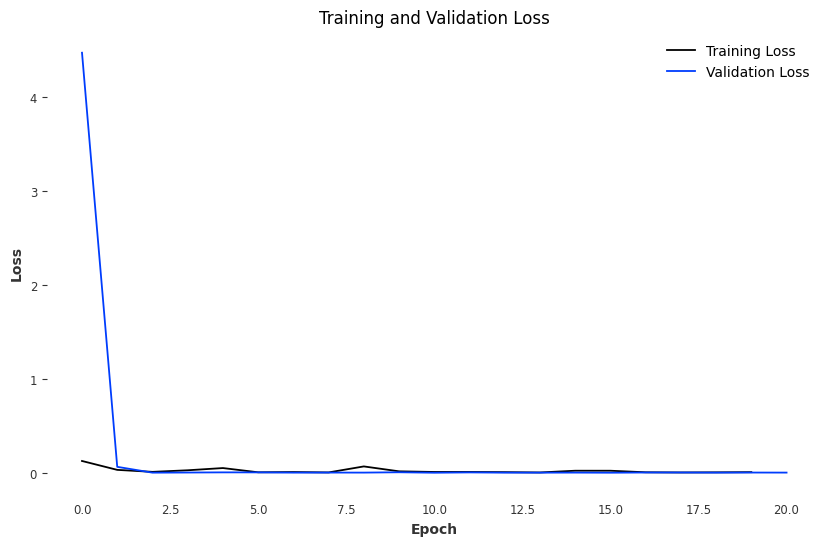

In [189]:
train_loss = loss_logger.train_loss  # Access train_loss from the callback
val_loss = loss_logger.val_loss      # Access val_loss from the callback

# Now you can use train_loss and val_loss for plotting or analysis
print(f"Final Train Loss: {train_loss[-1]:.4f}")  # Print the last recorded train loss
print(f"Final Validation Loss: {val_loss[-1]:.4f}")  # Print the last recorded validation loss

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()

In [141]:
# %tensorboard --logdir=tb_logs

In [192]:
# Sliding window prediction on test data
predictions = []

# Start with the initial window
start_idx = 0
end_idx = input_chunk_length

predictions.append( test_scaled[start_idx:end_idx])

# Slide the window across the test data
while end_idx + output_chunk_length <= len(test_scaled):
    # Extract the input window
    input_window = test_scaled[start_idx:end_idx]
    print("Length is: ", len(input_window))
    print("Start: ",start_idx)
    print("End: ",end_idx)

    # Make the prediction for the next `output_chunk_length` periods
    forecast = model.predict(n=output_chunk_length, series=input_window)

    # Store the forecast
    predictions.append(forecast)

    # Slide the window forward by input_chunk_length
    start_idx += output_chunk_length
    end_idx += output_chunk_length


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Length is:  30
Start:  0
End:  30


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Length is:  30
Start:  10
End:  40


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Length is:  30
Start:  20
End:  50


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Length is:  30
Start:  30
End:  60


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Length is:  30
Start:  40
End:  70


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Length is:  30
Start:  50
End:  80


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Length is:  30
Start:  60
End:  90


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Length is:  30
Start:  70
End:  100


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Length is:  30
Start:  80
End:  110


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Length is:  30
Start:  90
End:  120


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Length is:  30
Start:  100
End:  130


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Length is:  30
Start:  110
End:  140


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Length is:  30
Start:  120
End:  150


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Length is:  30
Start:  130
End:  160


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Length is:  30
Start:  140
End:  170


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Length is:  30
Start:  150
End:  180


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Length is:  30
Start:  160
End:  190


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Length is:  30
Start:  170
End:  200


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Length is:  30
Start:  180
End:  210


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Length is:  30
Start:  190
End:  220


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Length is:  30
Start:  200
End:  230


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Length is:  30
Start:  210
End:  240


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Length is:  30
Start:  220
End:  250


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Length is:  30
Start:  230
End:  260


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Length is:  30
Start:  240
End:  270


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Length is:  30
Start:  250
End:  280


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Length is:  30
Start:  260
End:  290


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Length is:  30
Start:  270
End:  300


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Length is:  30
Start:  280
End:  310


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Length is:  30
Start:  290
End:  320


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Length is:  30
Start:  300
End:  330


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Length is:  30
Start:  310
End:  340


Predicting: |          | 0/? [00:00<?, ?it/s]

In [163]:
sum=0
for i in predictions:
  sum+=len(i)

In [164]:
predictions.append(test_scaled[sum:len(test_scaled)])

In [ ]:
predicted_series = TimeSeries.from_times_and_values(
    times=test_scaled.time_index,  # Starting time index
    values=np.concatenate([forecast.values() for forecast in predictions], axis=0)
)

In [77]:
# # Assuming `train_series`, `val_series`, and `test_series` are already prepared
# # Define input and output chunk sizes
# input_chunk_length = 30  # Number of past observations used for prediction
# output_chunk_length = 10  # Number of future periods to predict

# # Train the N-BEATS model
# # Sliding window prediction on test data
# predictions = []

# # Start with the initial window
# start_idx = 0
# end_idx = input_chunk_length

# # Slide the window across the test data
# while end_idx + output_chunk_length <= len(test_scaled):
#     # Extract the input window
#     input_window = test_scaled[start_idx:end_idx]

#     # Make the prediction for the next `output_chunk_length` periods
#     forecast = model.predict(n=output_chunk_length, series=input_window)

#     # Store the forecast
#     predictions.append(input_window)
#     predictions.append(forecast)

#     # Slide the window forward by input_chunk_length + output_chunk_length
#     start_idx += input_chunk_length + output_chunk_length
#     end_idx += input_chunk_length +output_chunk_length


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [166]:
len(test_scaled.time_index)

353

10

In [ ]:
# # Combine all the predictions into a single series
# predicted_series = TimeSeries.from_times_and_values(
#     times=test_scaled.time_index,  # Starting time index
#     values=np.concatenate([forecast.values() for forecast in predictions], axis=0)
# )

In [167]:
predicted_series_unscaled = scaler.inverse_transform(predicted_series)
test_scaled_unscaled = scaler.inverse_transform(test_scaled)

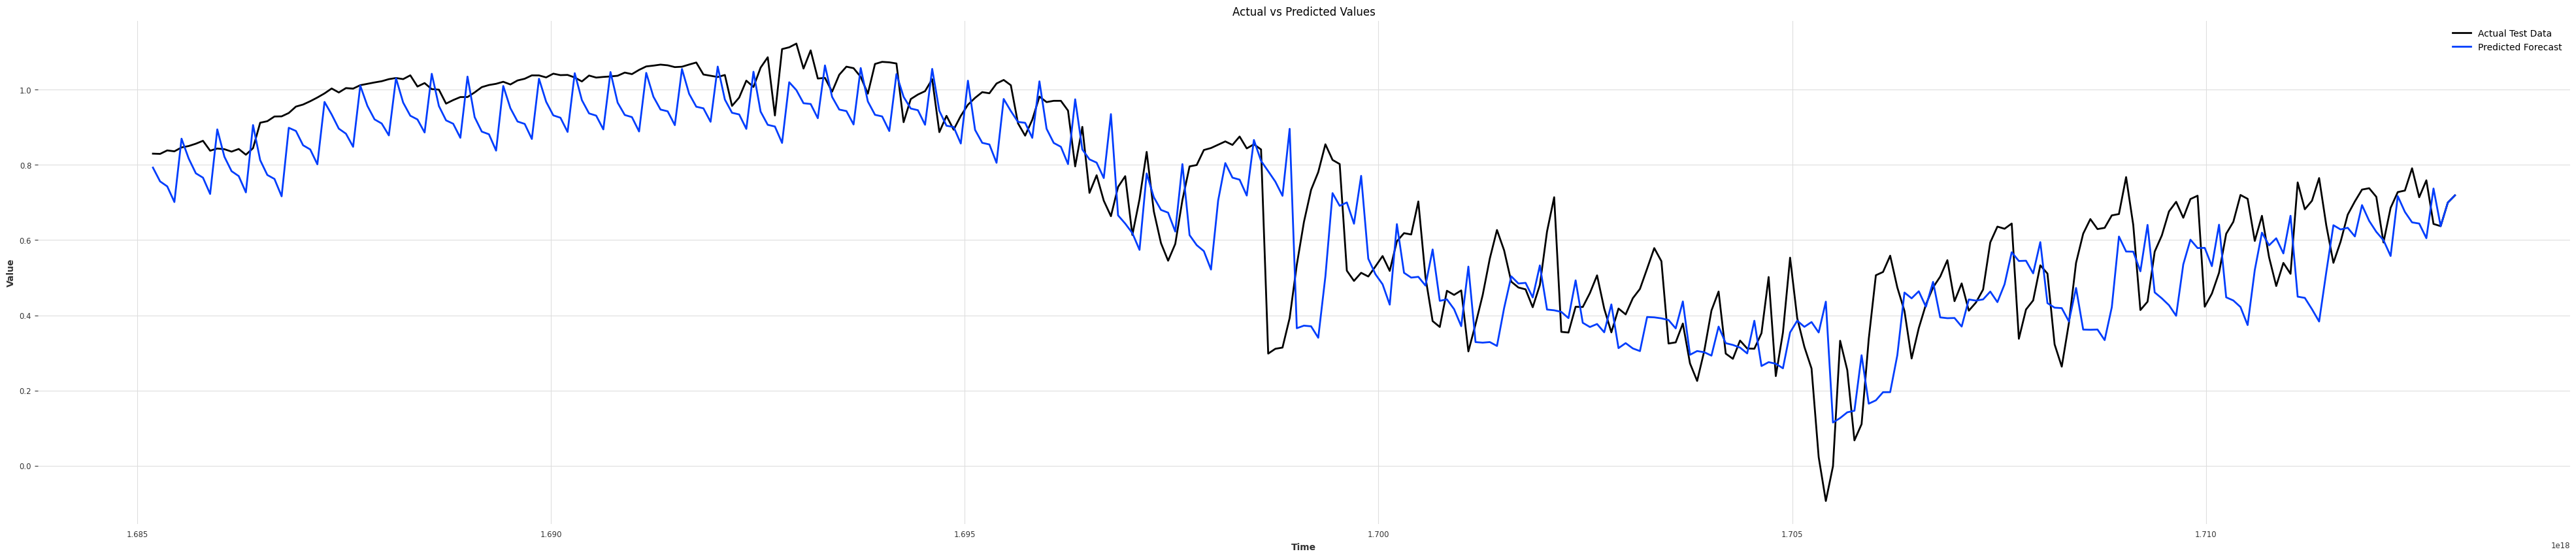

In [168]:
# Plot actual vs predicted values
plt.figure(figsize=(50, 10))
test_scaled[input_chunk_length:].plot(label="Actual Test Data")
predicted_series[input_chunk_length:].plot(label="Predicted Forecast")
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Actual vs Predicted Values")
plt.legend()
plt.show()


In [169]:
from darts.metrics import rmse, mae

rmse_val = rmse(test_scaled, predicted_series)
mae_val = mae(test_scaled, predicted_series)

print(f"RMSE: {rmse_val}")
print(f"MAE: {mae_val}")

RMSE: 0.14108655280288263
MAE: 0.10460615129036915
